# 이미지 당 객체 수 & 이미지 당 클래스 분포 EDA

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider, Button
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

## json 데이터 가져오기

In [2]:
src_root = '../dataset/'
src_subset = '../dataset/train'
src_file = src_root + 'train.json'
src_desc = 'train'

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [3]:
with open(src_file, 'r') as f:
    root = json.load(f)
    
root.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

## 간단한 josn 파일 구성 확인

In [4]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]




print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  train
Number of images:  4883
Number of bounding boxes:  23144
Number of classes:  10
Max min avg height:  1024 1024 1024
Max min avg width:  1024 1024 1024


In [5]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

## 이미지당 객체 수
- 0~5개 사이 : 3645 (76.4%)  
- 6~10개 사이 : 620 (12.6%)  
- 11~15개 사이 : 272 (5.5%)  
- 16~20개 사이 : 272 (3.3%)  
- 21~25개 사이 : 81 (1.6%)
- 26~30개 사이 : 51 (1.0%)
- 31~35개 사이 : 30 
- 36~40개 사이 : 11
- 41~45개 사이 : 4 
- 46~50개 사이 : 4 
- 51~55개 사이 : 2 
- 70~75개 사이 : 1 

-> 대부분의 데이터ㅏ 10개 아래의 객체를 포함하고 있음을 알 수 있다.

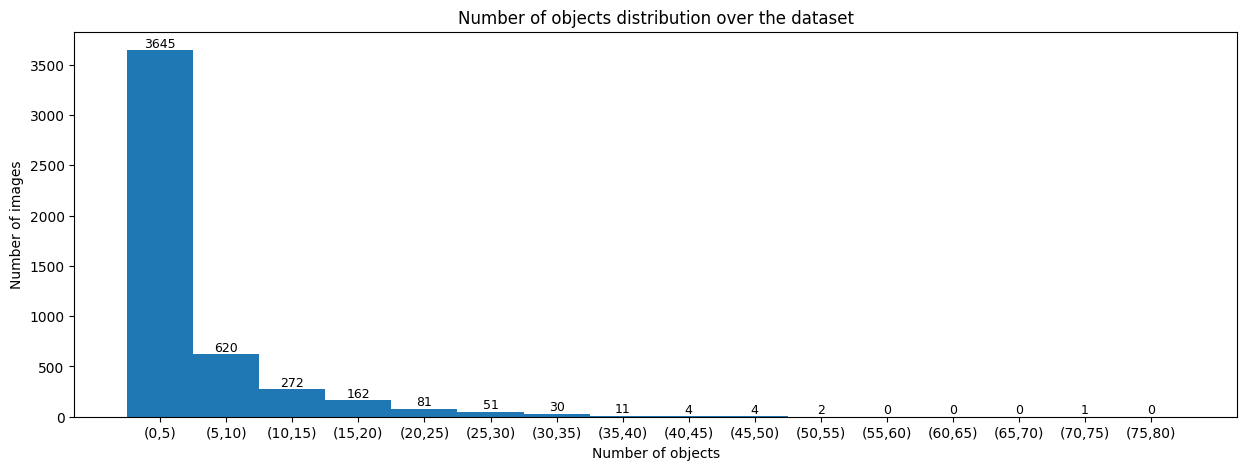

Number of images having atleast one box:  4883
Min number of boxes per image:  1
Max number of boxes per image:  71
Avg number of boxes per image:  4


In [6]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,5), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(15,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
for i, v in enumerate(graph_xind):
    plt.text(v, counts[i], counts[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')   
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

## 이미지 당 객체 분포
- 해당 코드 동작 시 각 이미지에 분포하는 객체들의 클래스 분포를 저장(함부로 실행하지 말 것!)

In [9]:
# Class distribution
for current_id in range(4883):
    class2nboxes = {} 
    for ann in root['annotations']:
        cat_id = ann['category_id']
        img_id = ann['image_id']
        if cat_id in class2nboxes.keys() and img_id == current_id:
            class2nboxes[cat_id] += 1
        elif cat_id not in class2nboxes.keys() and img_id == current_id:
            class2nboxes[cat_id] = 1
        elif cat_id not in class2nboxes.keys():
            class2nboxes[cat_id] = 0

        
    sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=False, key=lambda item: item[0])]

    # to plot
    categ_map = {x['id']: x['name'] for x in root['categories']}
    y = [i[1] for i in sorted_c2nb]
    x = [i[0] for i in sorted_c2nb]
    x = [categ_map[k] for k in x]
    plt.figure(figsize=(14,5))
    plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='royalblue')
    plt.xlim(-0.5,len(y))
    plt.xlabel('Category Id')
    plt.ylabel('Number of classes')
    plt.title(f'Class distribution of {current_id}')
    plt.savefig(f'{current_id}_class_distriubtion')
    #plt.show()
    plt.close() #prevent memory issues

## 클래스 별 bbox 사이즈 확인 및 정렬 시각화

In [10]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

0 -> General trash, 1 -> Paper, 2 -> Paper pack, 3 -> Metal, 4 -> Glass, 5 -> Plastic, 6 -> Styrofoam, 7 -> Plastic bag, 8 -> Battery, 9 -> Clothing, 

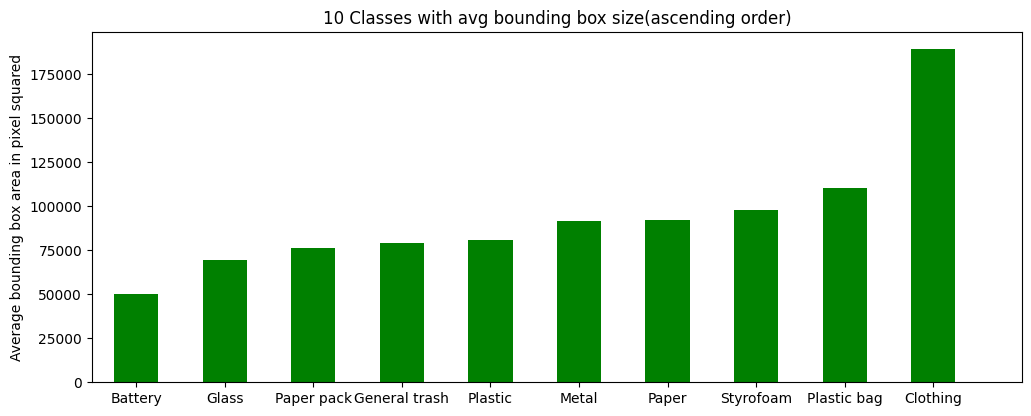

In [11]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(12,10))

categ_map = {x['id']: x['name'] for x in root['categories']}
y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]
x2 = [categ_map[k] for k in x2]
plt.subplot(211)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title(str(top)+ ' Classes with avg bounding box size(ascending order)')


for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## 학습 데이터에서의 클래스 객체 수 확인

{0: 3966, 3: 936, 7: 5178, 4: 982, 5: 2943, 2: 897, 6: 1263, 1: 6352, 9: 468, 8: 159}


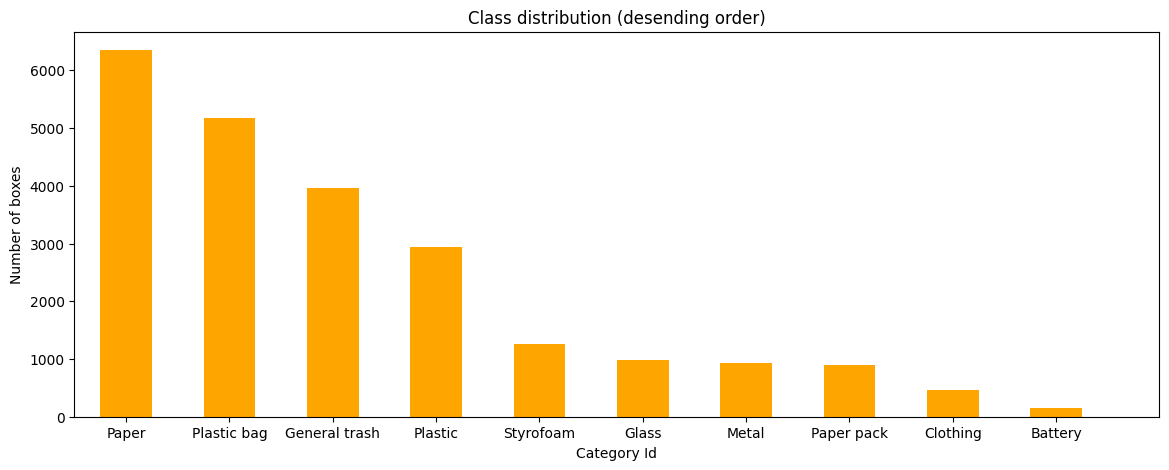

0 -> General trash, 1 -> Paper, 2 -> Paper pack, 3 -> Metal, 4 -> Glass, 5 -> Plastic, 6 -> Styrofoam, 7 -> Plastic bag, 8 -> Battery, 9 -> Clothing, 

In [12]:
# Class distribution
image_class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in image_class2nboxes.keys():
        image_class2nboxes[cat_id] += 1
    else:
        image_class2nboxes[cat_id] = 1
print(image_class2nboxes)
sorted_c2nb = [(k,v)for k, v in sorted(image_class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
categ_map = {x['id']: x['name'] for x in root['categories']}
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]
x = [categ_map[k] for k in x]
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (desending order)')
plt.show()



for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## 랜덤 시각화로 데이터 확인하기(Option)

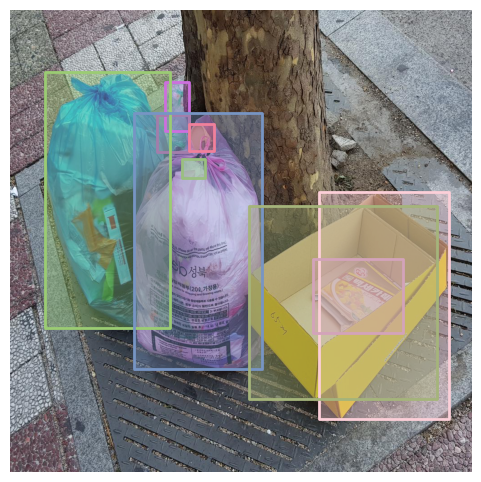

In [13]:
# generate a random image
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img_path= os.path.join(src_root, img['file_name'])
I = io.imread(img_path)

# plot annotations
plt.figure(figsize=(6,6))
plt.imshow(I)
plt.axis('off')
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)
for ann in anns:
    ann['segmentation'] = 0
#  disable segmentation
for a in anns:
    if 'segmentation' in a.keys():
        a['segmentation'] = []
coco_obj.showAnns(anns, draw_bbox=True)
classes = [categ_map[a['category_id']] for a in anns]